# Project 2: Mini deep-learning framework

You should be able to copy paste everything here to test.py

In [1]:
#!/usr/bin/env python3
""" File to solve the second miniproject which is the design of a framework """

import math
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import empty

__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

torch.set_grad_enabled(False)

In [2]:
from Linear import Linear
from Activation import Tanh, Relu, Sigmoid
from Loss import LossMSE, CrossEntropy
from Optimizers import Optimizers, Sgd, DecreaseSGD
from Sequential import Sequential

In [3]:
def compute_number_error(output_one_hot, target_one_hot):
    output = output_one_hot.argmax(dim=1)
    target = target_one_hot.argmax(dim=1)
    nb_of_error = (output != target).sum()
    return nb_of_error

## Data generation

In [4]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = empty(X.size())
    
    Y[:,0] = ((X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    Y[:,1] = ((X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    
    return X, Y

def plot_disc(data_in, data_target, title):
    plt.scatter(data_in[(data_target[:,1]==1),0] ,data_in[(data_target[:,1]==1),1], color = "c", s=20)
    plt.scatter(data_in[(data_target[:,1]==0),0] ,data_in[(data_target[:,1]==0),1], color = "g", s=20)
    plt.title(title)
    plt.legend(["1", "0"] )
    plt.show()
    
def plot_result(data_in, data_target, data_class):
    one_id_as_one = torch.mul( (data_target[:,1]==1), (data_class ==1 ))
    one_id_as_zero = torch.mul( (data_target[:,1]==1), (data_class ==0 ))
    zero_id_as_one = torch.mul( (data_target[:,1]==0), (data_class ==1 ))
    zero_id_as_zero = torch.mul( (data_target[:,1]==0), (data_class ==0 ))
    
    plt.scatter(data_in[one_id_as_one,0] ,data_in[one_id_as_one,1], color = "c", s=20)
    plt.scatter(data_in[zero_id_as_zero,0] ,data_in[zero_id_as_zero,1], color = "g", s=20)
    plt.scatter(data_in[one_id_as_zero,0] ,data_in[one_id_as_zero,1], color = "r", s=20)
    plt.scatter(data_in[zero_id_as_one,0] ,data_in[zero_id_as_one,1], color = "y", s=20)
    
    plt.title("Result on train data")
    plt.legend(["1 id as 1", "0 id as 0", "1 id as 0", "0 id as 1"] )
    plt.show()
    
def plot_loss(epochs, loss):
    plt.plot(epochs, loss)
    plt.title("Loss")

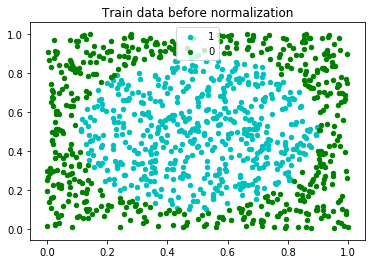

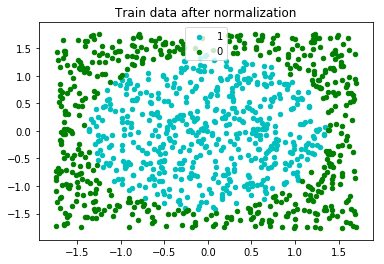

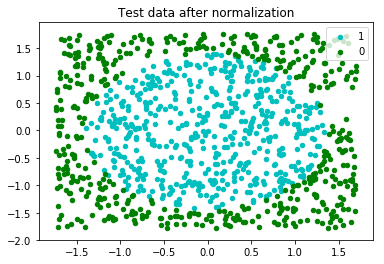

In [5]:
Sample_number = 1000
train_input, train_target = generate_disc_set(Sample_number)
test_input, test_target = generate_disc_set(Sample_number)


plot_disc(train_input, train_target, "Train data before normalization")

mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plot_disc(train_input, train_target, "Train data after normalization")
plot_disc(test_input, test_target, "Test data after normalization")

## Model 1: No dropout, constant learning rate

In [6]:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_1 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

my_loss_1 = []

model_1.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_1.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_1.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_1.backward()
        
        optimizer(model_1.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_1.append(loss_value.item())

0 :  0.6919651627540588
50 :  0.08537429571151733
100 :  0.024937132373452187
150 :  0.01154479943215847
200 :  0.006076660007238388
250 :  0.027800902724266052
300 :  0.014100341126322746
350 :  0.012271118350327015
400 :  0.005188598297536373
450 :  0.03540344163775444
500 :  0.014217528514564037
550 :  0.01402587816119194
600 :  0.0625787302851677
650 :  0.03214111179113388
700 :  0.0834948718547821
750 :  0.005600585602223873
800 :  0.0045410157181322575
850 :  0.04357665777206421
900 :  0.05282348394393921
950 :  0.08526977151632309



 
Loss:  0.009774414822459221
Number of errors:  2

 


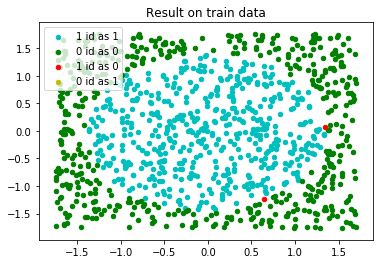

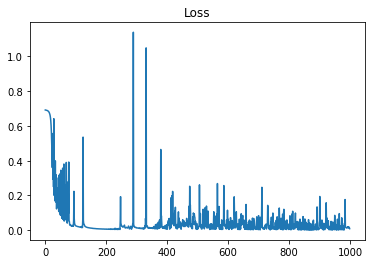

In [7]:
output = model_1.forward(train_input)
l = model_1.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_1)


 
Loss:  0.04423828423023224
Number of errors:  20

 


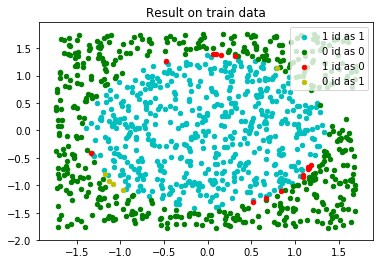

In [8]:
output = model_1.forward(test_input)
l = model_1.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 2: No dropout, deacreasing learning rate

In [9]:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_2 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

my_loss_2 = []

model_2.normalize_parameters(mean=0, std=std)
optimizer = DecreaseSGD()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_2.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_2.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_2.backward()
        
        optimizer(epochs, model_2.sequence)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_2.append(loss_value.item())

0 :  0.6923092603683472
50 :  0.6874392628669739
100 :  0.684520423412323
150 :  0.681958019733429
200 :  0.6795122623443604
250 :  0.6771337985992432
300 :  0.6748179197311401
350 :  0.6725009679794312
400 :  0.6701586842536926
450 :  0.6677810549736023
500 :  0.6653728485107422
550 :  0.6629365682601929
600 :  0.6604704260826111
650 :  0.6579688787460327
700 :  0.6554310321807861
750 :  0.6528590321540833
800 :  0.6502421498298645
850 :  0.647582471370697
900 :  0.6448743343353271
950 :  0.6421157121658325



 
Loss:  0.6428731679916382
Number of errors:  202

 


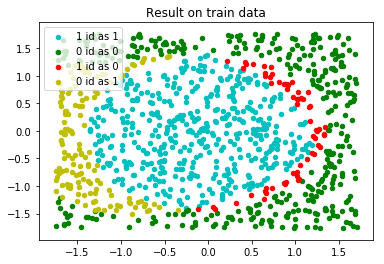

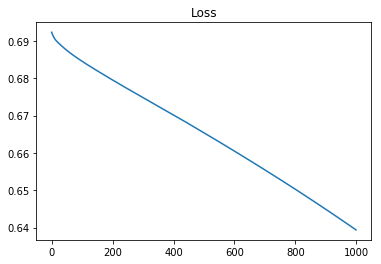

In [10]:
output = model_2.forward(train_input)
l = model_2.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_2)


 
Loss:  0.6470634937286377
Number of errors:  214

 


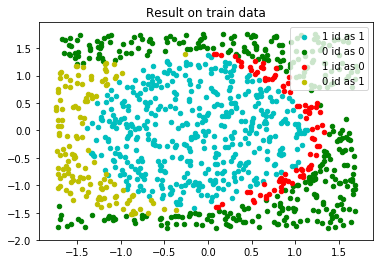

In [11]:
output = model_2.forward(test_input)
l = model_2.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 3: Dropout, constant learning rate

In [12]:
hidden_nb = 25
dropout = 0.25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb, dropout=dropout)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb, dropout=dropout)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_3 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

my_loss_3 = []

model_3.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_3.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_3.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_3.backward()
        
        optimizer(model_3.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_3.append(loss_value.item())

0 :  0.6924798488616943
50 :  0.39588087797164917
100 :  0.1946762055158615
150 :  0.08437500149011612
200 :  0.020199889317154884
250 :  0.010910644195973873
300 :  0.012615356594324112
350 :  0.014547728933393955
400 :  0.0845324695110321
450 :  0.02171020396053791
500 :  0.015610961243510246
550 :  0.03477111831307411
600 :  0.008612670935690403
650 :  0.012540893629193306
700 :  0.012500610202550888
750 :  0.053615111857652664
800 :  0.04964599385857582
850 :  0.03037719614803791
900 :  0.0044445800594985485
950 :  0.03806518390774727



 
Loss:  0.007810547016561031
Number of errors:  3

 


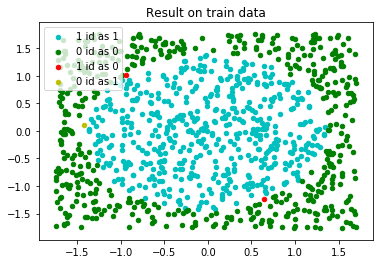

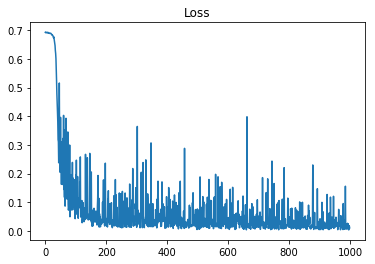

In [13]:
output = model_3.forward(train_input)
l = model_3.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_3)


 
Loss:  0.042241211980581284
Number of errors:  14

 


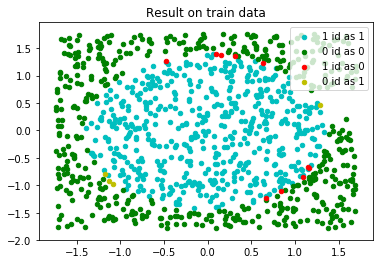

In [14]:
output = model_3.forward(test_input)
l = model_3.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## All graphs

Text(0.5, 0, 'Epochs')

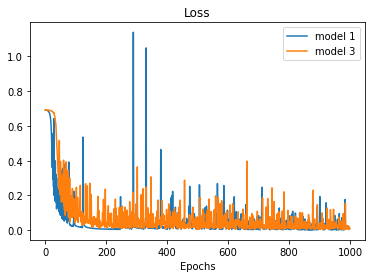

In [15]:


plt.plot(range(0, epochs_number), my_loss_1,  range(0, epochs_number), my_loss_3) #range(0, epochs_number), my_loss_2,
plt.legend(["model 1", "model 3"])
plt.title("Loss")
plt.xlabel("Epochs")